### Empirical Example Two for RobustiPy!

#### This example is designed to show how the LRobust class can be used to estimate a model with a binary dependent variable.

[The dataset](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction) provides insights into customer satisfaction levels within an undisclosed airline company. While the specific airline name is withheld, the dataset is rich in information, containing 22 columns and 129,880 rows. It aims to predict whether future customers will be satisfied based on various parameters included in the dataset.

The columns likely cover a range of factors that influence customer satisfaction, such as flight punctuality, service quality, and so. By analyzing this dataset, airlines can gain valuable insights into the factors that contribute to customer satisfaction and tailor their services accordingly to enhance the overall customer experience.

The dataset is provided under an Apache 2.0 license.

Let's first load the libraries that we'll need:

In [1]:
import os
import pandas as pd
from robustipy.models import LRobust

In [2]:
import kagglehub
import pandas as pd
import os
import shutil

# Download the dataset (returns the directory path)
dataset_dir = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

# Recursively search for CSV files in the downloaded directory.
csv_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

if not csv_files:
    raise ValueError("No CSV file found in the dataset directory.")

# Load the first CSV file found into a pandas DataFrame.
df = pd.read_csv(csv_files[0], index_col='id')

# Optionally, remove the downloaded dataset directory to avoid saving anything permanently.
shutil.rmtree(dataset_dir)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.71M/2.71M [00:00<00:00, 4.51MB/s]

Extracting files...


Then, let's do a little bit of cleaning of the dataset:

In [3]:
def clean_airline(df):
    df['satisfaction'] = pd.get_dummies(df['satisfaction'])['satisfied']
    df['satisfaction'] = df['satisfaction'].astype(int)
    df = df.dropna()
    return df
    
airline_df = clean_airline(df)

Lets have a quick look at the data:

In [4]:
airline_df.head(5)

,Unnamed: 0,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
70172,0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,0
5047,1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,0
110028,2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
24026,3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,0
119299,4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [5]:
print(f'How many rows do we have? {len(airline_df)}')

How many rows do we have? 103594


<Axes: >

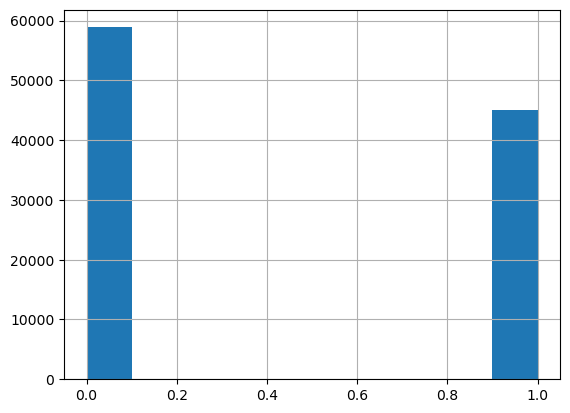

In [6]:
df['satisfaction'].hist()

Next, let's define our key variables as before: 

In [7]:
y = ['satisfaction']
x = ['Age']
c = ['Flight Distance',
     'Seat comfort', 
     'Food and drink',
     'Gate location',
     'On-board service',
     'Leg room service',
     'Baggage handling',
     'Checkin service',
     'Cleanliness'
    ]

Now, lets do some RobustiPy things:

In [8]:
# Lets call the LRobust class, similar but different to the example_one_union.ipynb
airline_robust = LRobust(y=y, x=x, data=airline_df)

# Now, lets 'fit' the model and vary over the controls
airline_robust.fit(controls=c,
                   draws=1000,
                   oos_metric='r-squared',
                   kfold=10,
                   seed=192735,
                  )

# Finally, get the results object that we'll need to visualise and print out the results:
airline_results = airline_robust.get_results()

[LRobust] Running with n_cpu=31, draws=1000


Output()

/home/jinx/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Visualise the results:

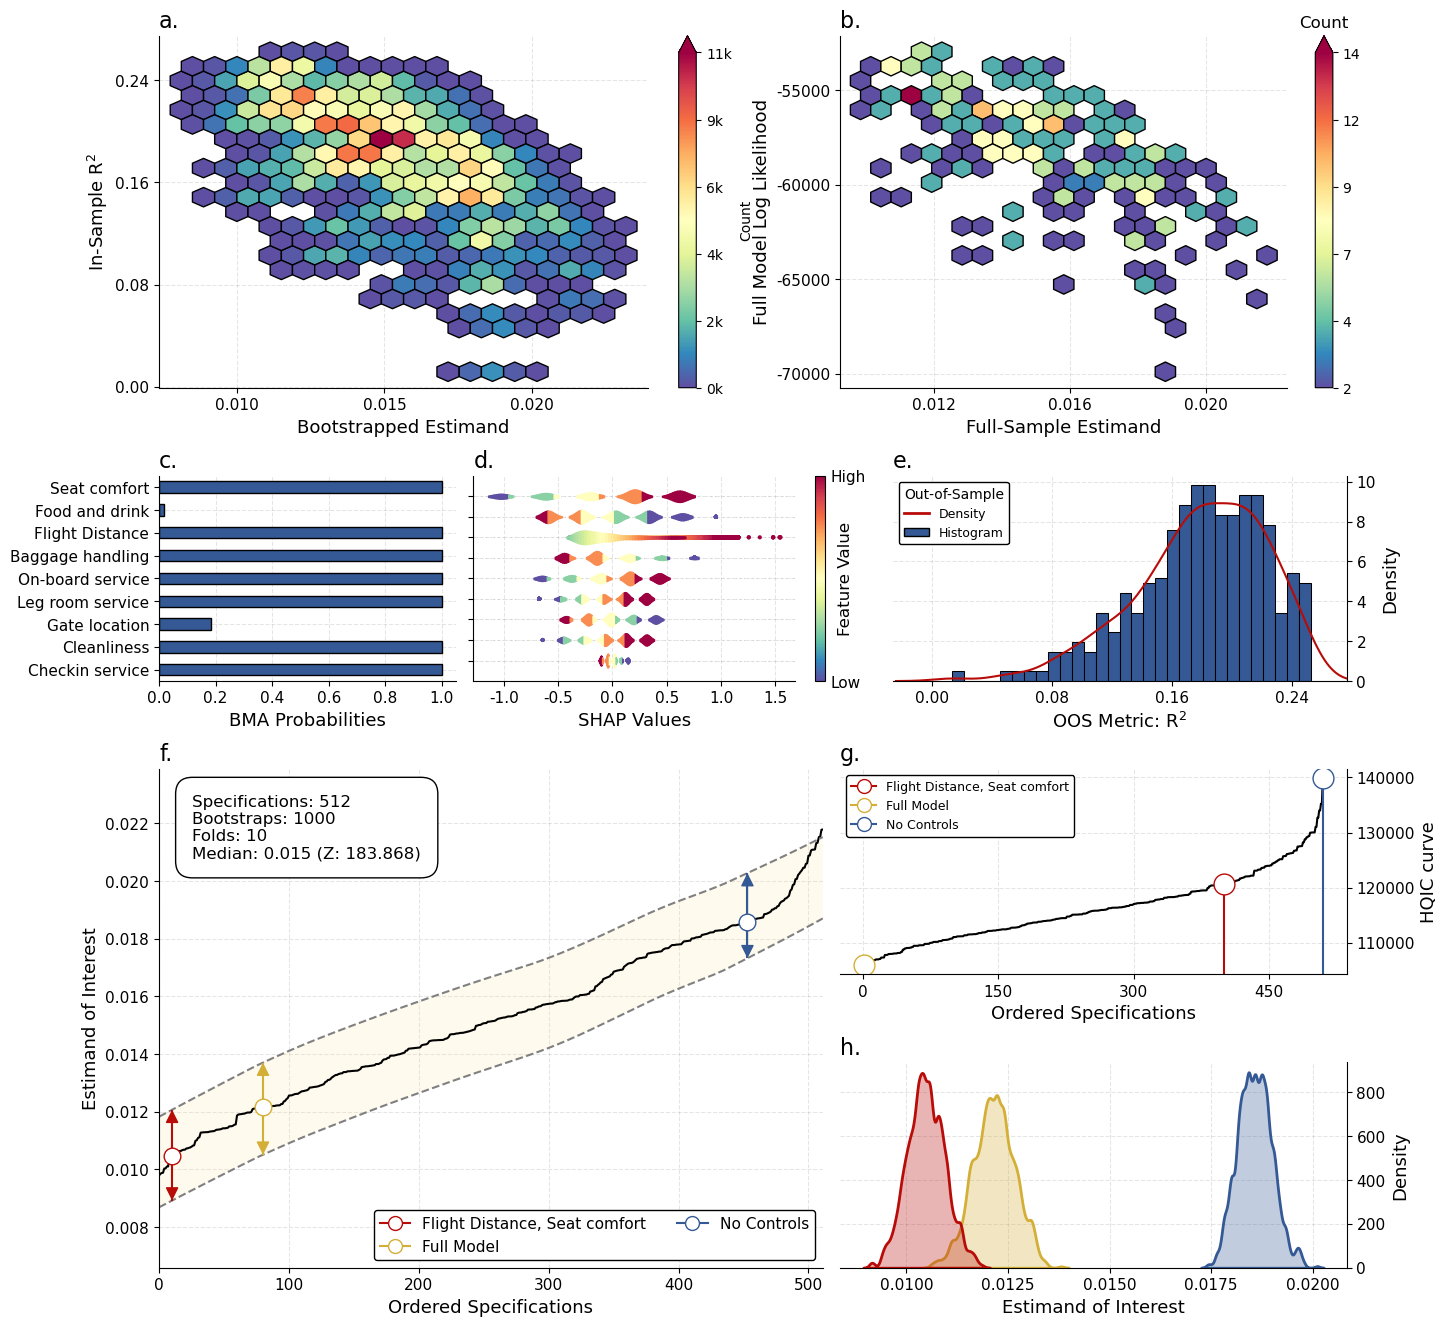

In [9]:
airline_results.plot(ic='hqic',
                    figsize=(16, 16),
                    specs=[['Flight Distance', 'Seat comfort']],
                    project_name='airline_example',
                    )

Print out a summary of the results:

In [10]:
airline_results.summary()

1. Model Summary
Model: Logistic Regression Robust
Inference Tests: No
Dependent variable: satisfaction
Independent variable: ['Age']
Number of possible controls: 9
Number of draws: 1000
Number of folds: 10
Number of specifications: 512
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 0.015
Median beta (all bootstraps and specifications): 0.015
Min beta (all specifications, no resampling): 0.01
Min beta (all bootstraps and specifications): 0.008
Max beta (all specifications, no resampling): 0.022
Max beta (all bootstraps and specifications): 0.023
AIC-weighted beta (all specifications, no resampling): 0.012
BIC-weighted beta (all specifications, no resampling): 0.012
HQIC-weighted beta (all specifications, no resampling): 0.012
Significant portion of beta (all specifications, no resampling): 1.0
Significant portion of beta (all bootstraps and specifications): 1.0
Positive portion of beta (all specifications, no resampling): 1.0
Positive 